# Library

In [621]:
# My library
from molgraph.dataset import *
from molgraph.testingconsensus import *
# pytorch
import torch

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

# Argument

In [622]:
parser = ArgumentParser()
args = parser.getArgument('''
--file bbbp
--model GIN
--schema AR_0
--reduced functional
--vocab_len 100
--mol_embedding 256
--batch_normalize
--fold 5
'''.split())
args

Namespace(batch_normalize=True, batch_size=256, class_number=1, device=device(type='cpu'), dropout=0.4, edge_dim=32, experiment_number='001', file='t02_aqsoldb_9982', fold=5, gpu=-1, grad_norm=1.0, graphtask='regression', heads=1, hidden_channels=256, in_channels=256, lr=5e-05, lr_schedule=True, model='GIN', mol_embedding=256, num_epochs=300, num_layers=3, num_layers_reduced=3, num_layers_self=3, num_layers_self_reduced=3, out_channels=256, patience=30, reduced=['functional'], schema='AR_0', seed=42, smiles='SMILES', splitting='random', splitting_seed=42, task='Solubility', vocab_len=100, weight_decay=5e-05)

# Dataset

In [623]:
file = args.file
smiles = args.smiles 
task = args.task
splitting = args.splitting 
splitting_fold = args.fold
splitting_seed = args.splitting_seed

# get validated dataset
datasets = getDataset(file, smiles, task, splitting)
# compute positive weight for classification
if args.graphtask == 'classification':
    args.pos_weight = getPosWeight(datasets)
    print('pos_weight:', args.pos_weight)
# generate dataset splitting
datasets_splitted = generateDatasetSplitting(file, splitting, splitting_fold, splitting_seed)
# generate all graph dataset
datasets_graph = generateGraphDataset(file)
# generate all reduced graph dataset
dict_reducedgraph = dict()
for g in args.reduced:
    if g == 'substructure':
        for i in range(splitting_fold):
            vocab_file = file+'_'+str(i)
            if not os.path.exists('vocab/'+vocab_file+'.txt'):
                generateVocabTrain(file, splitting_seed, splitting_fold, vocab_len=args.vocab_len)
            dict_reducedgraph[g] = generateReducedGraphDict(file, g, vocab_file=vocab_file)
    else:
        dict_reducedgraph[g] = generateReducedGraphDict(file, g)

Function: getDataset()
number of valid smiles: 9945
Function: generateDatasetSplitting()
Fold: 5
Fold Number: 0
-- Datasets Train: 6365
-- Datasets Val: 1591
-- Datasets Test:  1989
-- Total: 9945
Fold Number: 1
-- Datasets Train: 6365
-- Datasets Val: 1591
-- Datasets Test:  1989
-- Total: 9945
Fold Number: 2
-- Datasets Train: 6365
-- Datasets Val: 1591
-- Datasets Test:  1989
-- Total: 9945
Fold Number: 3
-- Datasets Train: 6365
-- Datasets Val: 1591
-- Datasets Test:  1989
-- Total: 9945
Fold Number: 4
-- Datasets Train: 6364
-- Datasets Val: 1592
-- Datasets Test:  1989
-- Total: 9945
Function: generateGraphDataset()
Datasets graph:  9945


# Test

In [625]:
import os
args_test = dict()

# Load model
ts = "2023-Apr-10-17:15:04"
args_test = dict()
reduced_list = '_'.join(args.reduced)
# directory = './dataset/'+os.path.join(*[args.file, args.model+'_'+args.schema+'_'+reduced_list])
# ts = next(os.walk(directory))[1][0]
reduced_list = '_'.join(args.reduced)
args_test['log_folder_name'] = os.path.join(*[args.file, args.model+'_'+args.schema+'_'+reduced_list, f"{ts}"])
args_test['exp_name'] = args.experiment_number
# args_test['fold_number'] = fold_number
args_test['seed'] = args.seed

training_bin = torch.load('./dataset/'+args_test['log_folder_name']+'/checkpoints/training_args.bin')

args.batch_size = training_bin.batch_size
args.num_layers = training_bin.num_layers
args.num_layers_reduced = training_bin.num_layers_reduced
args.in_channels = training_bin.in_channels
args.hidden_channels = training_bin.hidden_channels
args.out_channels = training_bin.out_channels
args.edge_dim = training_bin.edge_dim
args.num_layers_self = training_bin.num_layers_self
args.num_layers_self_reduced = training_bin.num_layers_self_reduced
args.dropout = training_bin.dropout
args.lr = training_bin.lr
args.weight_decay = training_bin.weight_decay
# print(args)


# Sample

In [634]:
# # test with single sample
testing_type = 'sample'
testing_smiles = 'CCCCCCC(=O)OCC(O)CO'
smiles_processes = mol_to_smiles(smiles_to_mol(testing_smiles, with_atom_index=False))
molecule_test = constructGraph(smiles_processes, 0)
datasets_test = {testing_smiles: molecule_test}

# test dataset original
# testing_type = 'test_dataset'
# test_loader, datasets_test =  generateDataLoaderTesting(args.file, args.batch_size)

# test dataset external
# testing_type = 'external'
# test_external = 'test_external.csv'
# datasets_test_df = pd.read_csv('dataset/'+args.file+'/'+test_external)
# datasets_test_list = []
# for idx, row in datasets_test_df.iterrows():
#     smiles_processes = mol_to_smiles(smiles_to_mol(row['X'], with_atom_index=False))
#     d = constructGraph(smiles_processes, row['y'])
#     datasets_test_list.append(d)
# test_loader, datasets_test =  generateDataLoaderListing(datasets_test_list, 1)
# datasets_test = {d.smiles: d for d in datasets_test}

# # all dataset
# testing_type = 'dataset'
# datasets_test = datasets_graph

all_dataset = datasets_test

# Running

In [635]:
print('Number of dataset:', len(all_dataset))

Number of dataset: 1


In [636]:
if testing_type == 'sample' or testing_type == 'external' or testing_type == 'test_dataset':
    prediction_fold_df = getPredictionFold(args, args_test, all_dataset, datasets_splitted=None)
    display(prediction_fold_df)
    prediction_consensus_df = getPredictionConsensus(prediction_fold_df)
    
elif testing_type == 'dataset':
    reduced_list = '_'.join(args.reduced)
    directory = args.model+'_'+args.schema+'_'+reduced_list
    path_fold = 'dataset/'+file+'/prediction_fold_'+args.file+'_'+directory+'.csv'
    path_consensus = 'dataset/'+file+'/prediction_consensus_'+args.file+'_'+directory+'.csv'
    prediction_fold_df = pd.DataFrame()
    prediction_consensus_df = pd.DataFrame()

    if os.path.exists(path_fold):
        prediction_fold_df = pd.read_csv(path_fold)
    else:
        prediction_fold_df = getPredictionFold(args, args_test, all_dataset, datasets_splitted=datasets_splitted)
        prediction_fold_df.to_csv(path_fold, index=False)

    if os.path.exists(path_consensus):
        prediction_consensus_df = pd.read_csv(path_consensus)
    else:
        prediction_consensus_df = getPredictionConsensus(prediction_fold_df)
        prediction_consensus_df.to_csv(path_consensus, index=False)


print('prediction_fold_df', len(prediction_fold_df))
print('prediction_consensus_df', len(prediction_consensus_df))

getMaskGraph: 100%|██████████| 1/1 [00:00<00:00, 13.89it/s]


,Fold,SMILES_original,SMILES,Split,Prediction,TrueValue,Schema,Node_ID,Node_Feature,Weight,Weight_Other
0,0,CCCCCCC(=O)OCC(O)CO,C[CH2:1][CH2:2][CH2:3][CH2:4][CH2:5][C:6](=[O:...,-,-1.303499,0.0,atom,0,[a] C,0.162855,NaN
1,0,CCCCCCC(=O)OCC(O)CO,C[CH2:1][CH2:2][CH2:3][CH2:4][CH2:5][C:6](=[O:...,-,-1.303499,0.0,atom,1,[a] C,0.202833,NaN
2,0,CCCCCCC(=O)OCC(O)CO,C[CH2:1][CH2:2][CH2:3][CH2:4][CH2:5][C:6](=[O:...,-,-1.303499,0.0,atom,2,[a] C,0.600035,NaN
3,0,CCCCCCC(=O)OCC(O)CO,C[CH2:1][CH2:2][CH2:3][CH2:4][CH2:5][C:6](=[O:...,-,-1.303499,0.0,atom,3,[a] C,0.615756,NaN
4,0,CCCCCCC(=O)OCC(O)CO,C[CH2:1][CH2:2][CH2:3][CH2:4][CH2:5][C:6](=[O:...,-,-1.303499,0.0,atom,4,[a] C,0.650250,NaN
...,...,...,...,...,...,...,...,...,...,...,...
36,4,CCCCCCC(=O)OCC(O)CO,C[CH2:1][CH2:2][CH2:3][CH2:4][CH2:5][C:6](=[O:...,-,-1.232308,0.0,x,9,[a] C,0.632253,NaN
37,4,CCCCCCC(=O)OCC(O)CO,C[CH2:1][CH2:2][CH2:3][CH2:4][CH2:5][C:6](=[O:...,-,-1.232308,0.0,x,10,[a] C,0.953825,NaN
38,4,CCCCCCC(=O)OCC(O)CO,C[CH2:1][CH2:2][CH2:3][CH2:4][CH2:5][C:6](=[O:...,-,-1.232308,0.0,x,11,[a] O,1.000000,NaN
39,4,CCCCCCC(=O)OCC(O)CO,C[CH2:1][CH2:2][CH2:3][CH2:4][CH2:5][C:6](=[O:...,-,-1.232308,0.0,x,12,[a] C,1.000000,NaN


prediction_fold_df 205
prediction_consensus_df 41


In [638]:
prediction_consensus_df.head()

,Fold,SMILES_original,SMILES,Split,Prediction,TrueValue,Schema,Node_ID,Node_Feature,Weight,Weight_Other
0,C,CCCCCCC(=O)OCC(O)CO,C[CH2:1][CH2:2][CH2:3][CH2:4][CH2:5][C:6](=[O:...,-,-1.457173,0.0,atom,0,[a] C,0.102593,NaN
1,C,CCCCCCC(=O)OCC(O)CO,C[CH2:1][CH2:2][CH2:3][CH2:4][CH2:5][C:6](=[O:...,-,-1.457173,0.0,atom,1,[a] C,0.107128,NaN
2,C,CCCCCCC(=O)OCC(O)CO,C[CH2:1][CH2:2][CH2:3][CH2:4][CH2:5][C:6](=[O:...,-,-1.457173,0.0,atom,2,[a] C,0.301124,NaN
3,C,CCCCCCC(=O)OCC(O)CO,C[CH2:1][CH2:2][CH2:3][CH2:4][CH2:5][C:6](=[O:...,-,-1.457173,0.0,atom,3,[a] C,0.305075,NaN
4,C,CCCCCCC(=O)OCC(O)CO,C[CH2:1][CH2:2][CH2:3][CH2:4][CH2:5][C:6](=[O:...,-,-1.457173,0.0,atom,4,[a] C,0.304612,NaN


# Interpretation

CCCCCCC(=O)OCC(O)CO
Prediction Result (class): {-1.4571730741438103}
graph_g {'atom': {0: 0.09219603982424063, 1: 0.09688800999605568, 2: 0.2975638624793222, 3: 0.3016506285939143, 4: 0.3011715918961939, 5: 0.298387546014162, 6: 0.0, 7: 0.5228028901667442, 8: 0.2282834509181551, 9: 0.4626024856848898, 10: 0.2962427156539102, 11: 0.9999999999999999, 12: 0.3465464898293187, 13: 0.9195562360467278}, 'bond': {}}


[10:11:31] The new font size 1 is below the current minimum (6).


graph_r {'atom': {0: 0.8923558682695006, 1: 0.9999999999999999, 2: 0.7486566846697409, 3: 0.22523166120085622, 4: 0.1827746863979188, 5: 0.18792841730947718, 6: 0.1813166115935752, 7: 0.16842148027877402, 8: 0.08477411178894922, 9: 0.0, 10: 0.09184311980146492, 11: 0.19046997137833713, 12: 0.5658308155859211}, 'bond': {}}


[10:11:31] The new font size 1 is below the current minimum (6).
[10:11:33] The new font size 1 is below the current minimum (6).
[10:11:33] The new font size 1 is below the current minimum (6).


graph_x {'atom': {0: 0.0, 1: 0.1270344932953149, 2: 0.27567392882950054, 3: 0.29464644774661913, 4: 0.29388676013433257, 5: 0.22203046794933945, 6: 0.42794734577471655, 7: 0.5213961144504042, 8: 0.1287136074825122, 9: 0.39309697242305586, 10: 0.9773998756197465, 11: 1.0, 12: 0.9155173556639049, 13: 0.9122041972789501}, 'bond': {}}


{'prediction': -1.4571730741438103,
 'graph_g': {'atom': {0: 0.09219603982424063,
   1: 0.09688800999605568,
   2: 0.2975638624793222,
   3: 0.3016506285939143,
   4: 0.3011715918961939,
   5: 0.298387546014162,
   6: 0.0,
   7: 0.5228028901667442,
   8: 0.2282834509181551,
   9: 0.4626024856848898,
   10: 0.2962427156539102,
   11: 0.9999999999999999,
   12: 0.3465464898293187,
   13: 0.9195562360467278},
  'bond': {}},
 'graph_r': {'atom': {0: 0.8923558682695006,
   1: 0.9999999999999999,
   2: 0.7486566846697409,
   3: 0.22523166120085622,
   4: 0.1827746863979188,
   5: 0.18792841730947718,
   6: 0.1813166115935752,
   7: 0.16842148027877402,
   8: 0.08477411178894922,
   9: 0.0,
   10: 0.09184311980146492,
   11: 0.19046997137833713,
   12: 0.5658308155859211},
  'bond': {}},
 'graph_x': {'atom': {0: 0.0,
   1: 0.1270344932953149,
   2: 0.27567392882950054,
   3: 0.29464644774661913,
   4: 0.29388676013433257,
   5: 0.22203046794933945,
   6: 0.42794734577471655,
   7: 0.521396114

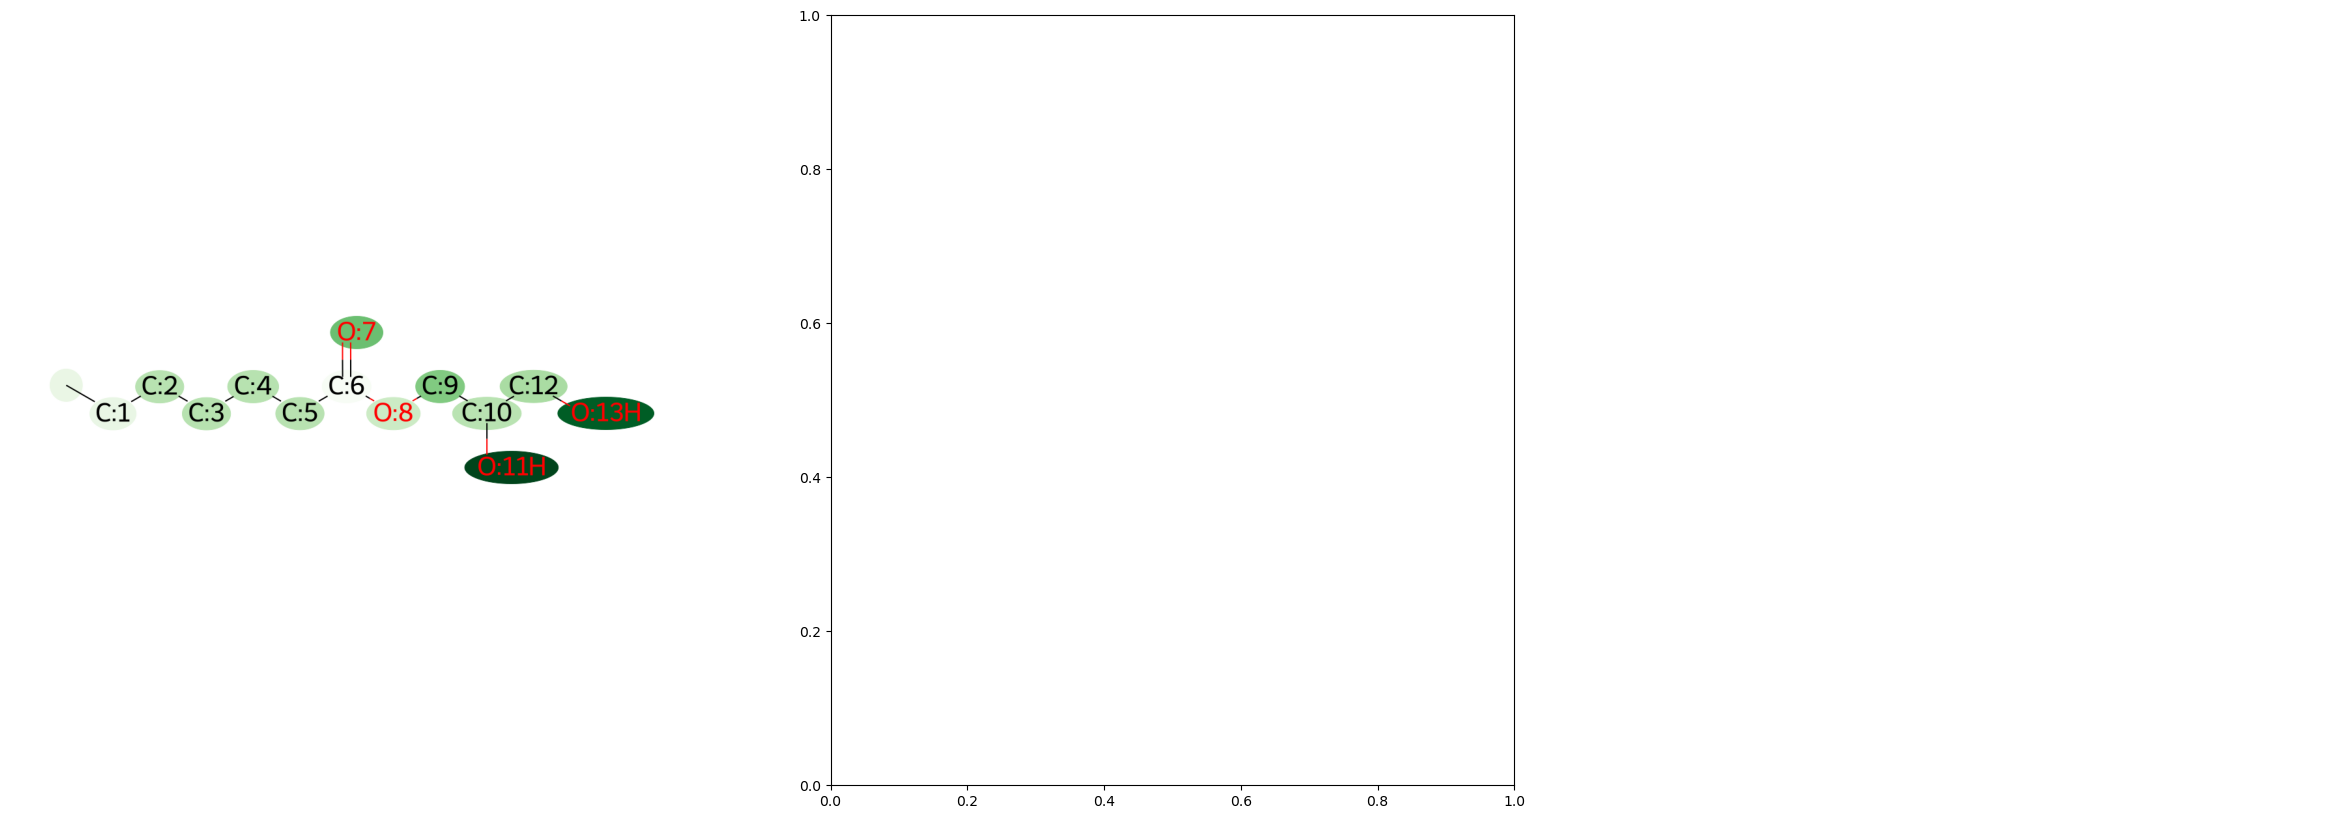

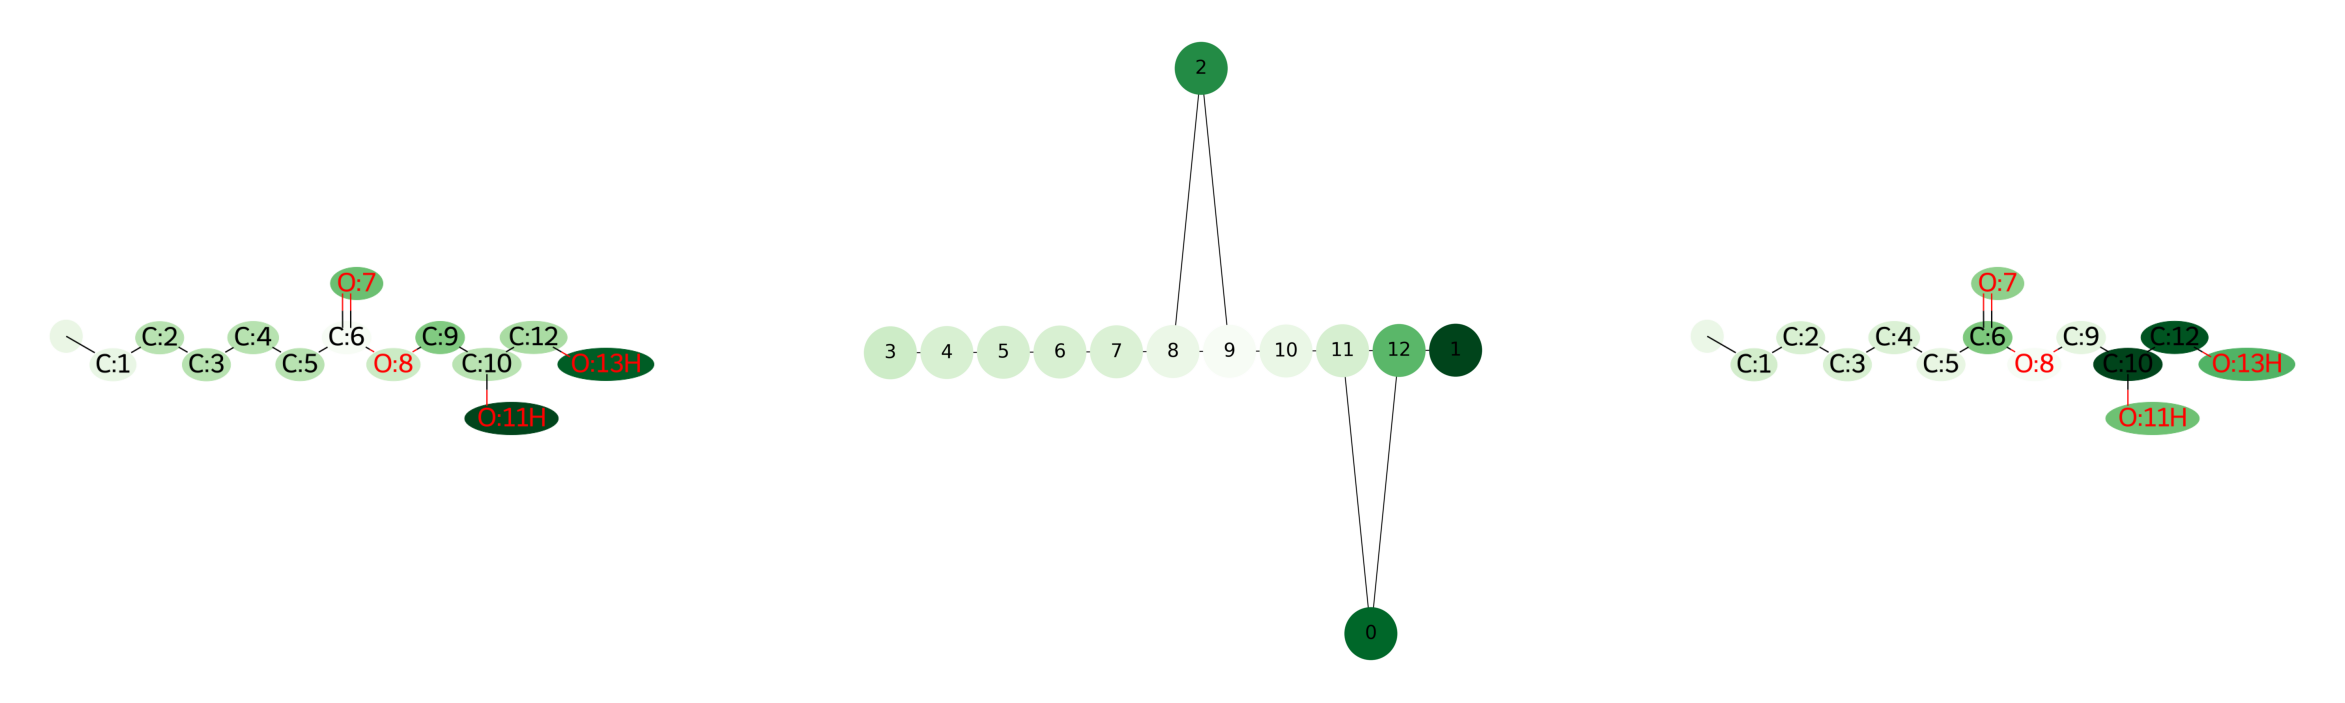

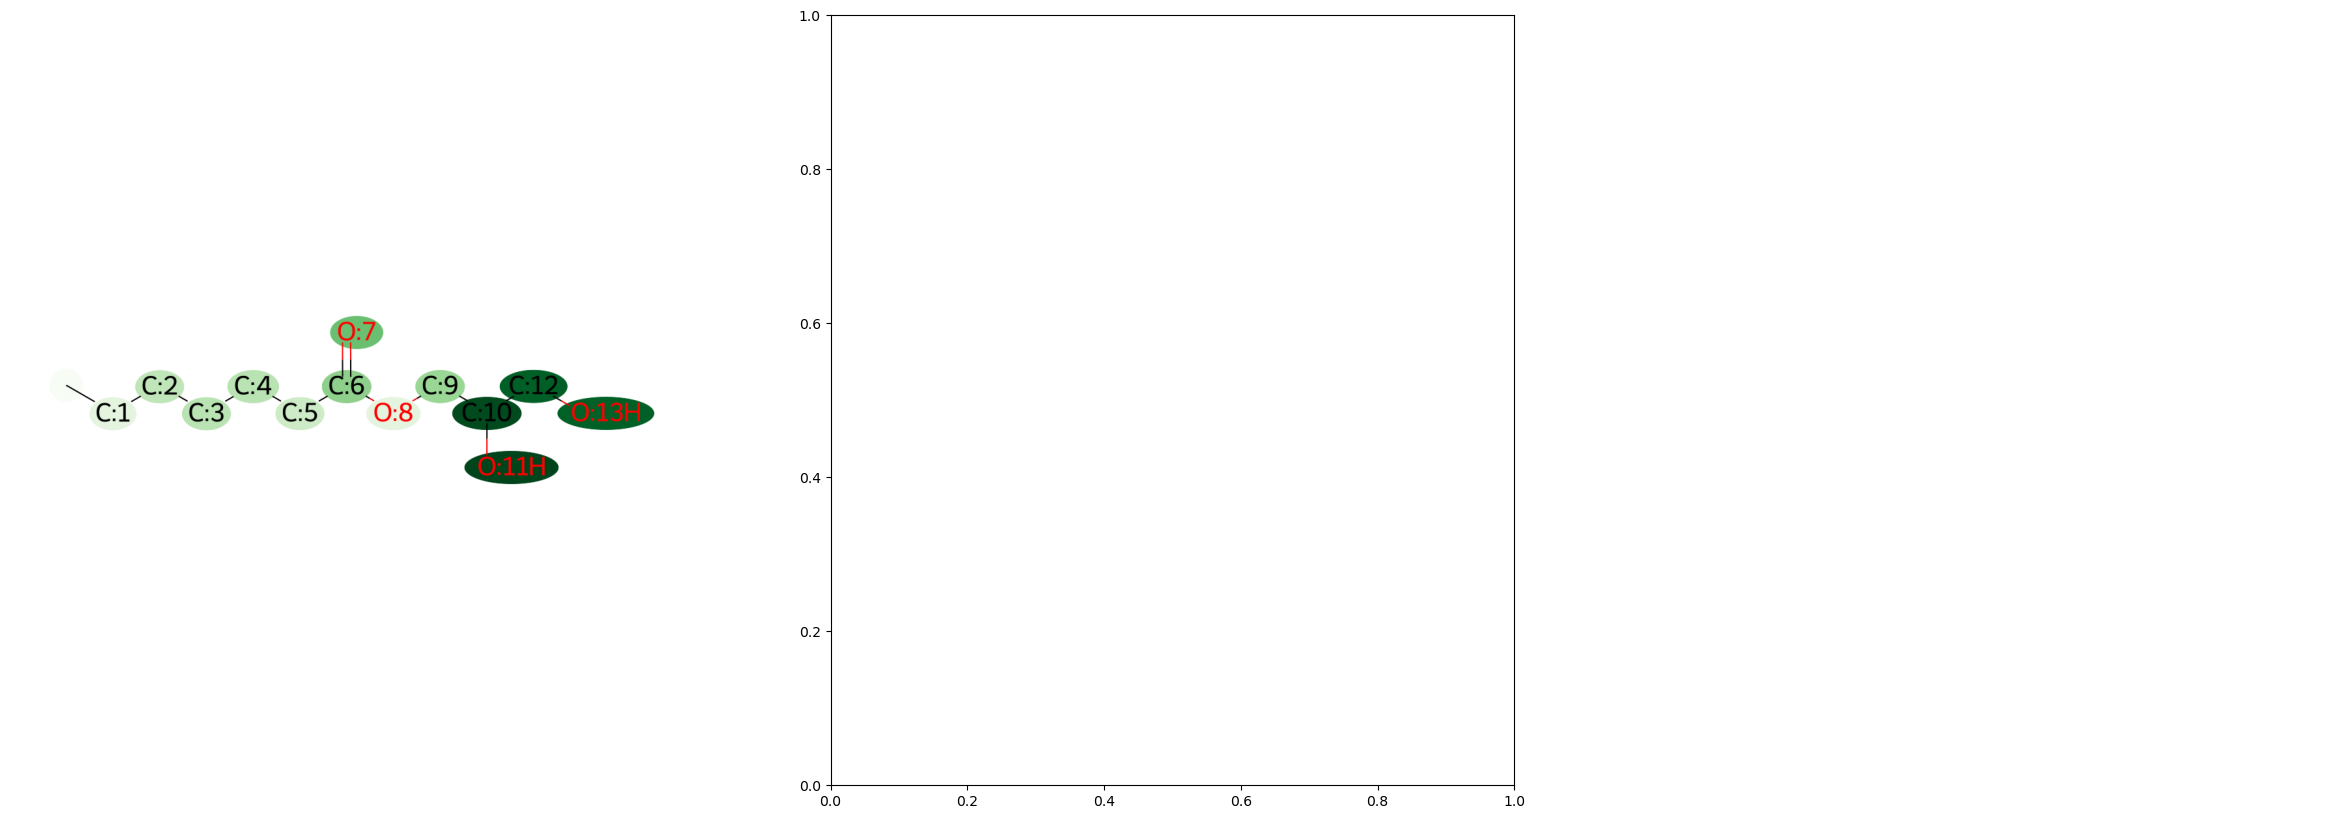

In [639]:
if testing_type == 'sample':
    smiles_test = Chem.MolToSmiles(Chem.MolFromSmiles(testing_smiles))
else:
    smiles_test = Chem.MolToSmiles(Chem.MolFromSmiles('O=C1NC(=O)SC1Cc4ccc(OCC3(Oc2c(c(c(O)c(c2CC3)C)C)C)C)cc4'))
    
prediction_mol_df = prediction_consensus_df[prediction_consensus_df['SMILES_original'] == smiles_test]
prediction_mol_df
print(smiles_test)
getPrediction(prediction_mol_df, args, print_result=True)

# Performance

In [640]:
if args.graphtask == 'classification' and len(prediction_consensus_df) > 1:
    prediction_consensus_df_unique = prediction_consensus_df.drop_duplicates(subset=['SMILES_original'])
    print(accuracy_score(prediction_consensus_df_unique['TrueValue'], [i>=0.5 for i in prediction_consensus_df_unique['Prediction']]))